In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

In [92]:
def get_auc_scores(clf, X_train, X_test, y_train, y_test):
    '''Prints the AUC scores for training and testing data
    and returns testing score'''

    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]
    print('Training AUC:' , roc_auc_score(y_train, y_train_score))
    print('Testing AUC: ', roc_auc_score(y_test, y_test_score))
 
    return y_test_score

def plot_roc_curve(y_test, y_test_score):
    '''Plot ROC curve for testing data'''
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], 'k — ')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='lower right')
    plt.show()

#https://medium.com/swlh/how-to-code-and-evaluate-of-decision-trees-2d94093b3c1a

In [93]:
path = pd.read_csv("../Data/cleansed_final.csv")

In [95]:
final = path[["MSI","Under50","TILS", "Stage12", "Signet", "RightSide","NoNecrosis", "Mucin", "ModDiff", "HistHet", "Female", "Expansile", "CrohnMissing", "Crohn", "AngioLymph"]]

In [96]:
# dont use NoNecrosis; turn the feature handling around

In [97]:
final

,MSI,Under50,TILS,Stage12,Signet,RightSide,NoNecrosis,Mucin,ModDiff,HistHet,Female,Expansile,CrohnMissing,Crohn,AngioLymph
0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,1,0,1,1,0,0,1,1,0,0,0,1,0,1,0
4,0,0,0,1,0,1,0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0
1906,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0
1907,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1908,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [98]:
## fix random seed
import random
random.seed(222)

In [99]:
X = final.drop("MSI", axis=1)

In [100]:
y = final["MSI"]

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=.3, random_state=1)

In [102]:
## use smote to deal with imbalanced data by oversampling
oversample = SMOTE(random_state = 1)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

## Naive Bayes Classifier

In [103]:
bnb = BernoulliNB()

In [104]:
bnb.fit(X_smote,y_smote)

BernoulliNB()

In [105]:
features = list(X_test.columns)

In [106]:
features

['Under50',
 'TILS',
 'Stage12',
 'Signet',
 'RightSide',
 'NoNecrosis',
 'Mucin',
 'ModDiff',
 'HistHet',
 'Female',
 'Expansile',
 'CrohnMissing',
 'Crohn',
 'AngioLymph']

Training AUC: 0.6516114160638306
Testing AUC:  0.7620048173012863


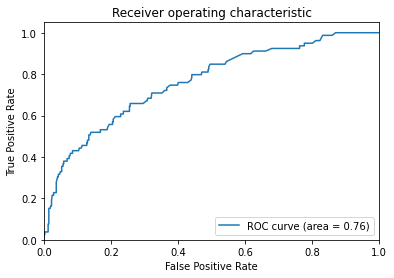

In [107]:
## AUC ROC curve
y_test_score = get_auc_scores(gnb, X_smote, X_test, y_smote, y_test)

plot_roc_curve(y_test, y_test_score)

In [110]:
imps = permutation_importance(bnb, X_test, y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. ModDiff (0.020244)
2. RightSide (0.015009)
3. NoNecrosis (0.007330)
4. Under50 (0.002792)
5. CrohnMissing (0.002443)
6. Mucin (0.001396)
7. Signet (0.001047)
8. HistHet (0.000698)
9. AngioLymph (0.000349)
10. Expansile (-0.000349)
11. Female (-0.000349)
12. TILS (-0.002443)
13. Stage12 (-0.004188)
14. Crohn (-0.010820)


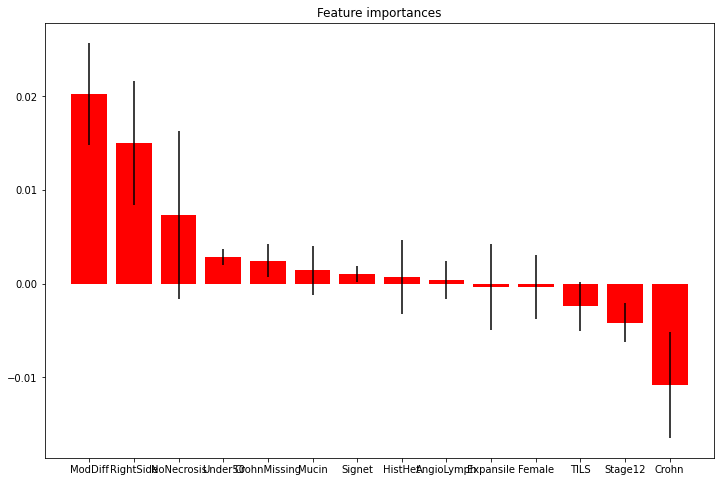

In [111]:
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(14)])
plt.xlim([-1, X_test.shape[1]])
plt.show()